In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
def simulate_gbm(S0,mu,sigma,T,dt,N_simulations):
    """
    Simulate Geometric Brownian Motion paths.

    Parameters:
    - S0: Initial stock price
    - mu: Drift (expected return)
    - sigma: Volatility
    - T: Time horizon (in years)
    - dt: Time step size
    - N_simulations: Number of simulation paths

    Returns:
    - A numpy array of shape (N_simulations, T/dt) containing the simulated stock price paths.
    """
    N_steps = int(T/dt)
    t=np.linspace(0,T,N_steps)

    dW = np.random.normal(0,np.sqrt(dt), (N_simulations, N_steps))
    W=np.cumsum(dW,axis=1)

    S_t=S0*np.exp((mu-0.5*sigma**2)*t+sigma*W)
    return t, S_t

# Parameters for simulation
S0 = 100  # Initial stock price
mu = 0.05  # Drift coefficient
sigma = 0.2  # Volatility coefficient
T = 1.0  # Time horizon (1 year)
dt = 1/252  # Time step size (assuming 252 trading days in a year)
N_simulations = 100  # Number of simulation paths

# Run simulation
t, simulated_paths = simulate_gbm(S0, mu, sigma, T, dt, N_simulations)


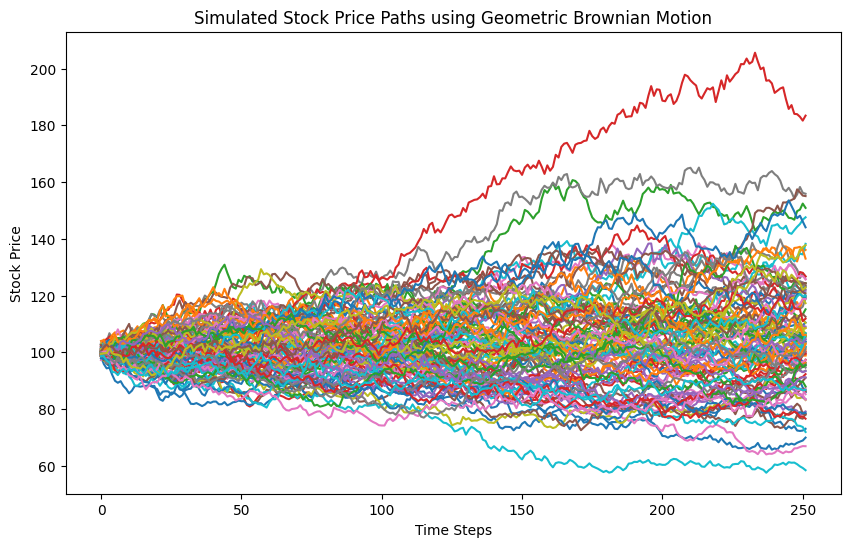

In [3]:
# Plot multiple simulated paths
plt.figure(figsize=(10, 6))
plt.plot(simulated_paths.T)
plt.title('Simulated Stock Price Paths using Geometric Brownian Motion')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()


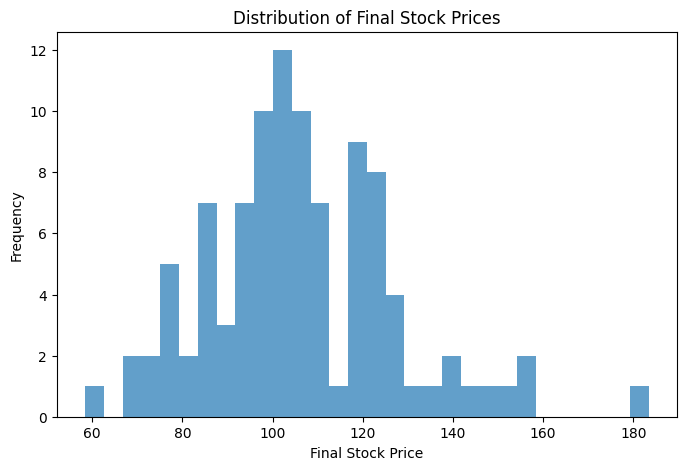

In [4]:
# Plot histogram of final stock prices
plt.figure(figsize=(8, 5))
plt.hist(simulated_paths[:, -1], bins=30, alpha=0.7)
plt.title('Distribution of Final Stock Prices')
plt.xlabel('Final Stock Price')
plt.ylabel('Frequency')
plt.show()


In [6]:
def monte_carlo_option_pricing(S0, K, T, r, sigma, N_simulations, option_type='call'):
    """
    Estimate the price of European call or put options using Monte Carlo simulation.

    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - sigma: Volatility
    - N_simulations: Number of simulation paths
    - option_type: 'call' or 'put'

    Returns:
    - Estimated option price.
    """
    dt = T
    _, simulated_paths = simulate_gbm(S0, r, sigma, T, dt, N_simulations)  # Use the simulate_gbm function
    final_prices = simulated_paths[:, -1]

    if option_type == 'call':
        payoffs = np.maximum(final_prices - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - final_prices, 0)

    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

# Parameters for option pricing
K = 100  # Strike price
r = 0.05  # Risk-free interest rate
option_type = 'call'  # Option type 'call'

# Estimate option prices using Monte Carlo simulation
call_price = monte_carlo_option_pricing(S0, K, T, r, sigma, N_simulations, option_type='call')
put_price = monte_carlo_option_pricing(S0, K, T, r, sigma, N_simulations, option_type='put')

print(f"Estimated European Call Option Price: {call_price:.2f}")
print(f"Estimated European Put Option Price: {put_price:.2f}")


Estimated European Call Option Price: 7.58
Estimated European Put Option Price: 6.62


[*********************100%***********************]  1 of 1 completed


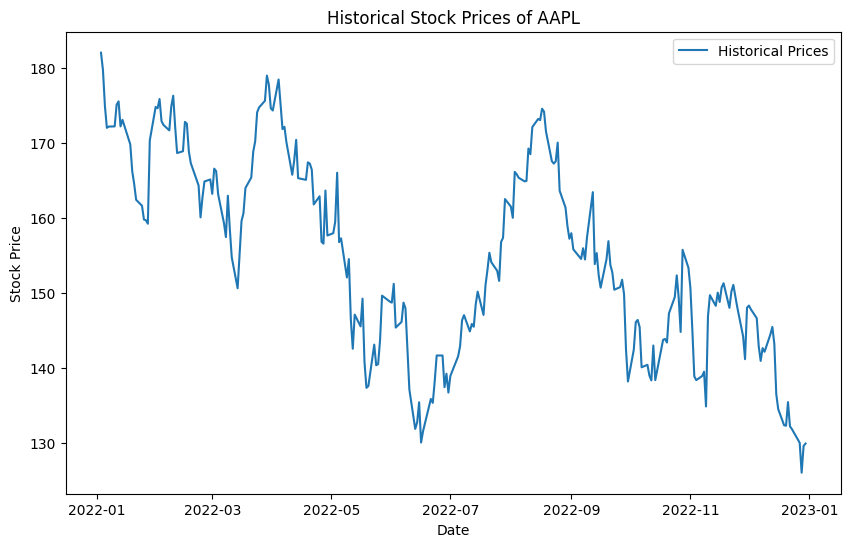

In [7]:
# Retrieve historical stock data using yfinance
stock_data = yf.download('AAPL', start='2022-01-01', end='2023-01-01')
stock_prices = stock_data['Close']

# Plot historical stock prices
plt.figure(figsize=(10, 6))
plt.plot(stock_prices, label='Historical Prices')
plt.title('Historical Stock Prices of AAPL')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [12]:
# Normalize historical prices for comparison
normalized_historical = stock_prices / stock_prices.iloc[0]

# Simulate GBM with the same number of steps as historical data length
t, simulated_paths = simulate_gbm(S0, mu, sigma, T, dt, N_simulations)

# Create a date range matching the historical data
simulated_dates = pd.date_range(start=stock_prices.index[0], periods=simulated_paths.shape[1], freq='B')


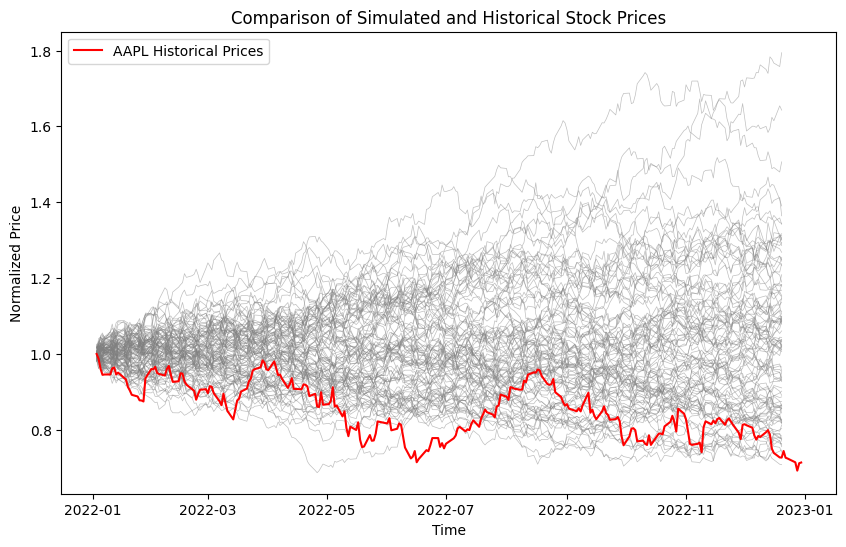

In [13]:
# Plot
plt.figure(figsize=(10, 6))

# Plot normalized simulated paths using the date range
for path in simulated_paths:
    plt.plot(simulated_dates, path / S0, color='gray', alpha=0.5, linewidth=0.5)

# Plot normalized historical prices
plt.plot(stock_prices.index, normalized_historical, color='red', label='AAPL Historical Prices')

plt.title('Comparison of Simulated and Historical Stock Prices')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

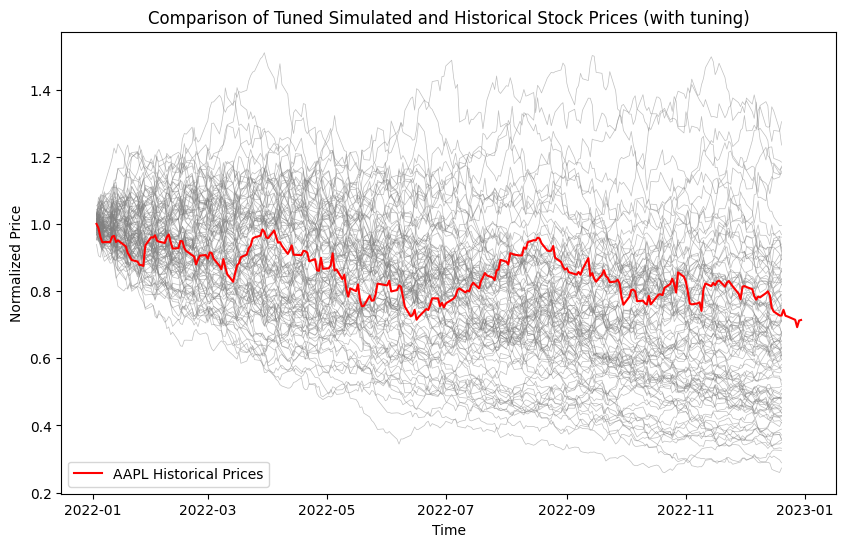

Estimated Drift (mu): -0.3398
Estimated Volatility (sigma): 0.3561


In [20]:
# Calculate daily returns and estimate drift (mu) and volatility (sigma)
log_returns = np.log(stock_prices / stock_prices.shift(1)) # Logarithmic returns
mu_estimated = log_returns.mean() * 252  # Annual drift
sigma_estimated = log_returns.std() * np.sqrt(252)  # Annual volatility


# Simulate GBM using estimated parameters
t, tuned_simulated_paths = simulate_gbm(S0, mu_estimated, sigma_estimated, T, dt, N_simulations)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot normalized simulated paths using the estimated parameters
for path in tuned_simulated_paths:
    plt.plot(simulated_dates, path / S0, color='gray', alpha=0.5, linewidth=0.5)

# Plot normalized historical prices
plt.plot(stock_prices.index, normalized_historical, color='red', label='AAPL Historical Prices')

plt.title('Comparison of Tuned Simulated and Historical Stock Prices (with tuning)')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

# Print the estimated parameters
print(f"Estimated Drift (mu): {mu_estimated:.4f}")
print(f"Estimated Volatility (sigma): {sigma_estimated:.4f}")
